In [1]:
#! /usr/bin/env python3
# coding: utf-8


import numpy as np
from os import path as pt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from stop_words import get_stop_words
from sklearn.model_selection import KFold
import pandas as pd
import xgboost as xgb
from scipy.sparse import csr_matrix
import csv


n_folds = 5
my_seed = 0

# tfidf
def get_tfidf_vectorizer(df, field, vectorizer):
    tfidf = vectorizer.fit_transform(df[field])
    tfidf_cols = vectorizer.get_feature_names()
    temp = pd.DataFrame(data=tfidf.todense(), columns=['tfidf_' + field + '_' + i for i in tfidf_cols])
    df = pd.concat([df, temp], axis=1)
    return df

#custom tokenizer for tfifd
def custom_tokenizer(s):
    return s.split(',')


#count agregate
def get_count(df, field, by_field):
    tmp=df[[by_field]+[field]].copy()
    tmp[field].fillna('xxx', inplace=True)
    tmp = tmp.groupby([by_field]).count()[[field]].reset_index()
    tmp.columns = [i for i in [by_field]]+['count_of_' + field + '_by_' + str(by_field)]
    df = df.merge(tmp, on=by_field, how='left')
    return df


#distinct count agregate
def get_distinct_count(df, field, by_field):
    tmp=df[[by_field]+[field]].copy()
    tmp[field].fillna('xxx', inplace=True)
    tmp = tmp[[by_field]+[field]]
    tmp = tmp.drop_duplicates(inplace=False)
    tmp = tmp.groupby([by_field]).count()[[field]].reset_index()
    tmp.columns = [i for i in [by_field]]+['distinct_count_of_' + field + '_by_' + str(by_field)]
    df = df.merge(tmp, on=by_field, how='left')
    return df


# xgb predict
def get_xgb_prediction(number_round, params, train_df, test_df, target_df):
    d_train = xgb.DMatrix(csr_matrix(train_df), label=target_df)
    d_test = xgb.DMatrix(csr_matrix(test_df))
    print('training')
    clf = xgb.train(params, d_train, number_round)
    print('predicting')
    preds = clf.predict(d_test)
    return preds



from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('max_columns', 200)

# Load data

In [2]:
train = pd.read_csv("X_train.csv", index_col=0, error_bad_lines=False)
test = pd.read_csv("X_test.csv", index_col=0, error_bad_lines=False)
target = pd.read_csv("y_train.csv", index_col=0)


target=target['delai_vente']
ntrain=len(train)
train_test = pd.concat((train, test), axis=0)
train_test=train_test.reset_index(drop=True)

#create french stop-words list
stop_words = list(get_stop_words('fr'))
nltk_words = list(stopwords.words('french'))
stop_words.extend(nltk_words)


train_test.head()

b'Skipping line 2168: expected 31 fields, saw 33\nSkipping line 4822: expected 31 fields, saw 37\nSkipping line 4859: expected 31 fields, saw 37\nSkipping line 7342: expected 31 fields, saw 37\n'


,nb_images,longueur_image,largeur_image,url_image,description_produit,taille,matiere,age,garantie,annee,couleur,largeur_produit,wifi,etat,longueur_produit,pointure,vintage,marque,auteur,editions,hauteur_produit,poids,prix,categorie,sous_categorie_1,sous_categorie_2,sous_categorie_3,sous_categorie_4,nom_produit,nom_magasin
0,3,3458.0,2552.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Superbe petit top bustier avec explosion de co...,44,100 % polyester,NaN,NaN,NaN,Multicolore,NaN,NaN,bon état,NaN,NaN,False,NaN,NaN,NaN,NaN,200.0,4.5,mode,"tops, t-shirts, débardeurs femme",NaN,NaN,NaN,Top bustier multicolore,Emmaüs 88 Neufchateau
1,2,2486.0,2254.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,"Radio ITT Océnic Flirt, année 70\nPour déco",NaN,Plastique,NaN,NaN,NaN,Jaune,NaN,NaN,en l'état,NaN,NaN,True,ITT Océanic,NaN,NaN,NaN,1000.0,15.0,mobilier - deco,bibelots et objets déco,NaN,NaN,NaN,Radio ITT Océanic,Communauté Emmaüs Thouars (magasin Parthenay)
2,3,1536.0,1536.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Veste boléro à manches courtes NÛMPH. Gris chi...,40,"Polyester, coton, laine",NaN,NaN,NaN,Gris,NaN,NaN,neuf,NaN,NaN,False,Nûmph,NaN,NaN,NaN,360.0,16.0,label selection,mode,mode femme,NaN,NaN,NaN,Label Emmaüs Chambéry
3,2,1100.0,1100.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Encrier plumier en verre. De forme carrée le ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bon état,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520.0,24.0,mobilier - deco,autres objets,NaN,NaN,NaN,Encrier Plumier en verre,Emmaüs Lyon
4,2,450.0,450.0,https://d1kvfoyrif6wzg.cloudfront.net/assets/i...,Si vous souhaitez acquérir un appareil puissan...,NaN,NaN,NaN,6 mois,NaN,Blanc,NaN,True,reconditionné,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0,139.0,multimédia,smartphones,NaN,NaN,NaN,HUAWEI Honor 5X Blanc - Débloqué - Très bon état.,La Bootique des Ateliers du Bocage


# Feature Engineering

In [3]:
###################################################################
####################### Aggregate features ########################
###################################################################
train_test=get_count(train_test, "nom_produit", 'nom_magasin')
train_test=get_distinct_count(train_test, "nom_produit", 'nom_magasin')




###################################################################
######################## tf-idf features ##########################
###################################################################
train_test['sous_categorie_1'] = train_test['sous_categorie_1'].astype(str)
train_test=get_tfidf_vectorizer(train_test,'sous_categorie_1', TfidfVectorizer(analyzer='word', 
                                                                        ngram_range=(1,3), 
                                                                        stop_words = stop_words, 
                                                                        lowercase=True, 
                                                                        max_features=50, 
                                                                        binary=True, 
                                                                        norm=None, 
                                                                        use_idf=False, tokenizer=custom_tokenizer))# tokenizer=custom_tokenizer,
train_test.drop('sous_categorie_1', inplace=True, axis=1)


train_test['sous_categorie_2'] = train_test['sous_categorie_2'].astype(str)
train_test=get_tfidf_vectorizer(train_test,'sous_categorie_2', TfidfVectorizer(analyzer='word', 
                                                                        ngram_range=(1,3), 
                                                                        stop_words = stop_words, 
                                                                        lowercase=True, 
                                                                        max_features=50, 
                                                                        binary=True, 
                                                                        norm=None, 
                                                                        use_idf=False))# tokenizer=custom_tokenizer,
train_test.drop('sous_categorie_2', inplace=True, axis=1)



train_test['description_produit'] = train_test['description_produit'].astype(str)
train_test=get_tfidf_vectorizer(train_test,'description_produit', TfidfVectorizer(analyzer='word', 
                                                                        ngram_range=(1,3), 
                                                                        stop_words = stop_words, 
                                                                        lowercase=True, 
                                                                        max_features=50, 
                                                                        binary=True, 
                                                                        norm=None, 
                                                                        use_idf=False))# tokenizer=custom_tokenizer,
train_test.drop('description_produit', inplace=True, axis=1)



###################################################################
################ label encode non numerical features ##############
###################################################################
for col in train_test.columns:
    if train_test[col].dtype == 'object':
        train_test[col] = train_test[col].astype('category').cat.codes


###################################################################
################## replace nan value and downcast #################
###################################################################
train_test.fillna(value=-999, inplace=True)


###################################################################
################ get train, test, release memory ##################
###################################################################

train = train_test.iloc[:ntrain, :]
test = train_test.iloc[ntrain:, :]
        
        

train.head(3)

,nb_images,longueur_image,largeur_image,url_image,taille,matiere,age,garantie,annee,couleur,largeur_produit,wifi,etat,longueur_produit,pointure,vintage,marque,auteur,editions,hauteur_produit,poids,prix,categorie,sous_categorie_3,sous_categorie_4,nom_produit,nom_magasin,count_of_nom_produit_by_nom_magasin,distinct_count_of_nom_produit_by_nom_magasin,tfidf_sous_categorie_1_ antiquités,tfidf_sous_categorie_1_ blazers femme,tfidf_sous_categorie_1_ blouses,tfidf_sous_categorie_1_ blouses tuniques femme,tfidf_sous_categorie_1_ débardeurs femme,tfidf_sous_categorie_1_ déco murale,tfidf_sous_categorie_1_ maroquinerie,tfidf_sous_categorie_1_ miroirs,tfidf_sous_categorie_1_ miroirs déco murale,tfidf_sous_categorie_1_ pulls femme,tfidf_sous_categorie_1_ shorts femme,tfidf_sous_categorie_1_ t-shirts,tfidf_sous_categorie_1_ t-shirts débardeurs femme,tfidf_sous_categorie_1_ tuniques femme,tfidf_sous_categorie_1_ vaisselle en lots,tfidf_sous_categorie_1_accessoires femme,tfidf_sous_categorie_1_appareils photo et accessoires photo,tfidf_sous_categorie_1_autres objets,tfidf_sous_categorie_1_bibelots et objets déco,tfidf_sous_categorie_1_chaussures et bottes femme,tfidf_sous_categorie_1_chemisiers,tfidf_sous_categorie_1_chemisiers blouses,tfidf_sous_categorie_1_chemisiers blouses tuniques femme,tfidf_sous_categorie_1_gilets,tfidf_sous_categorie_1_gilets pulls femme,tfidf_sous_categorie_1_jupes,tfidf_sous_categorie_1_jupes shorts femme,tfidf_sous_categorie_1_label selection,tfidf_sous_categorie_1_manteaux,tfidf_sous_categorie_1_mobilier - deco,tfidf_sous_categorie_1_mode,tfidf_sous_categorie_1_nan,tfidf_sous_categorie_1_objets d'art,tfidf_sous_categorie_1_objets d'art antiquités,tfidf_sous_categorie_1_pantalons femme,tfidf_sous_categorie_1_robes,tfidf_sous_categorie_1_sacs,tfidf_sous_categorie_1_sacs maroquinerie,tfidf_sous_categorie_1_services de vaisselle,tfidf_sous_categorie_1_services de vaisselle vaisselle en lots,tfidf_sous_categorie_1_tableaux,tfidf_sous_categorie_1_tableaux miroirs,tfidf_sous_categorie_1_tableaux miroirs déco murale,tfidf_sous_categorie_1_tops,tfidf_sous_categorie_1_tops t-shirts,tfidf_sous_categorie_1_tops t-shirts débardeurs femme,tfidf_sous_categorie_1_vaisselle à l'unité,tfidf_sous_categorie_1_vestes,tfidf_sous_categorie_1_vestes blazers femme,tfidf_sous_categorie_1_vinyles,tfidf_sous_categorie_2_accessoires,tfidf_sous_categorie_2_accessoires maroquinerie,tfidf_sous_categorie_2_anciens,tfidf_sous_categorie_2_autres,tfidf_sous_categorie_2_autres objets,tfidf_sous_categorie_2_bibelots,tfidf_sous_categorie_2_bibelots objets,tfidf_sous_categorie_2_bibelots objets déco,tfidf_sous_categorie_2_bois,tfidf_sous_categorie_2_bottes,tfidf_sous_categorie_2_chaussures,tfidf_sous_categorie_2_chaussures bottes,tfidf_sous_categorie_2_coeur,tfidf_sous_categorie_2_coeur vendeurs,tfidf_sous_categorie_2_coups,tfidf_sous_categorie_2_coups coeur,tfidf_sous_categorie_2_coups coeur vendeurs,tfidf_sous_categorie_2_deco,tfidf_sous_categorie_2_déco,tfidf_sous_categorie_2_déco vaisselle,tfidf_sous_categorie_2_femme,tfidf_sous_categorie_2_gilets,tfidf_sous_categorie_2_gilets pulls,tfidf_sous_categorie_2_gilets pulls femme,tfidf_sous_categorie_2_homme,tfidf_sous_categorie_2_jeux,tfidf_sous_categorie_2_jeux jouets,tfidf_sous_categorie_2_jouets,tfidf_sous_categorie_2_jouets bois,tfidf_sous_categorie_2_label,tfidf_sous_categorie_2_label selection,tfidf_sous_categorie_2_loisirs,tfidf_sous_categorie_2_maroquinerie,tfidf_sous_categorie_2_mobilier,tfidf_sous_categorie_2_mobilier deco,tfidf_sous_categorie_2_mode,tfidf_sous_categorie_2_mode femme,tfidf_sous_categorie_2_mode homme,tfidf_sous_categorie_2_nan,tfidf_sous_categorie_2_objets,tfidf_sous_categorie_2_objets déco,tfidf_sous_categorie_2_objets déco vaisselle,tfidf_sous_categorie_2_pulls,tfidf_sous_categorie_2_pulls femme,tfidf_sous_categorie_2_robes,tfidf_sous_categorie_2_selection,tfidf_sous_categorie_2_vaisselle,tfidf_sous_categorie_2_vendeurs,tfidf_sous_categorie_2_vintage,tfidf_sous_categorie_2_v

# Crossvalidate number of tree

In [4]:
xgb_params = {
    'nthread':4,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'colsample_bytree': 1,#1
    'silent': 1,
    'subsample': 0.8,#0.8
    'learning_rate': 0.05,#0.05
    'max_depth': 6,#6
    'min_child_weight': 7,#7
    'lambda': 1,#4
    'alpha': 1#6
}



d_train = xgb.DMatrix(csr_matrix(train), label=target)

res = xgb.cv(xgb_params, d_train, num_boost_round=100000, nfold=n_folds, 
                 early_stopping_rounds=200,
                 verbose_eval=100, show_stdv=True, seed=my_seed)

best_round = res.shape[0] - 1
cv_mean = np.round(res.iloc[-1, 0], 4)
cv_std = np.round(res.iloc[-1, 1], 4)

print('\n')
print('#', n_folds, 'fold-CV of xgboost : {0}+{1} @ seed={2}, eta={3} , bestRound={4}'
          .format(cv_mean, cv_std, my_seed, xgb_params["learning_rate"], best_round))
print('\n', '\n')


# 5 fold-CV of xgboost : 0.9185+0.0094 @ seed=0, eta=0.05 , bestRound=335

[0]	train-mlogloss:1.08852+0.000439466	test-mlogloss:1.09061+0.000300082
[100]	train-mlogloss:0.814941+0.00405288	test-mlogloss:0.937694+0.0061157
[200]	train-mlogloss:0.723807+0.00319928	test-mlogloss:0.92352+0.00788005
[300]	train-mlogloss:0.649424+0.00236363	test-mlogloss:0.919142+0.0089251
[400]	train-mlogloss:0.587507+0.00298432	test-mlogloss:0.919058+0.0102058
[500]	train-mlogloss:0.533651+0.00287068	test-mlogloss:0.921751+0.0103916


# 5 fold-CV of xgboost : 0.9185+0.0094 @ seed=0, eta=0.05 , bestRound=335

 



# train, predict and make submission

In [7]:
predictions = get_xgb_prediction(best_round, xgb_params, train, test, target)
df_submission = pd.DataFrame(predictions, index=test.index)
df_submission.to_csv("xgb.csv", index_label="id", header=['0', '1', '2'])

training
predicting


# plot feature importance

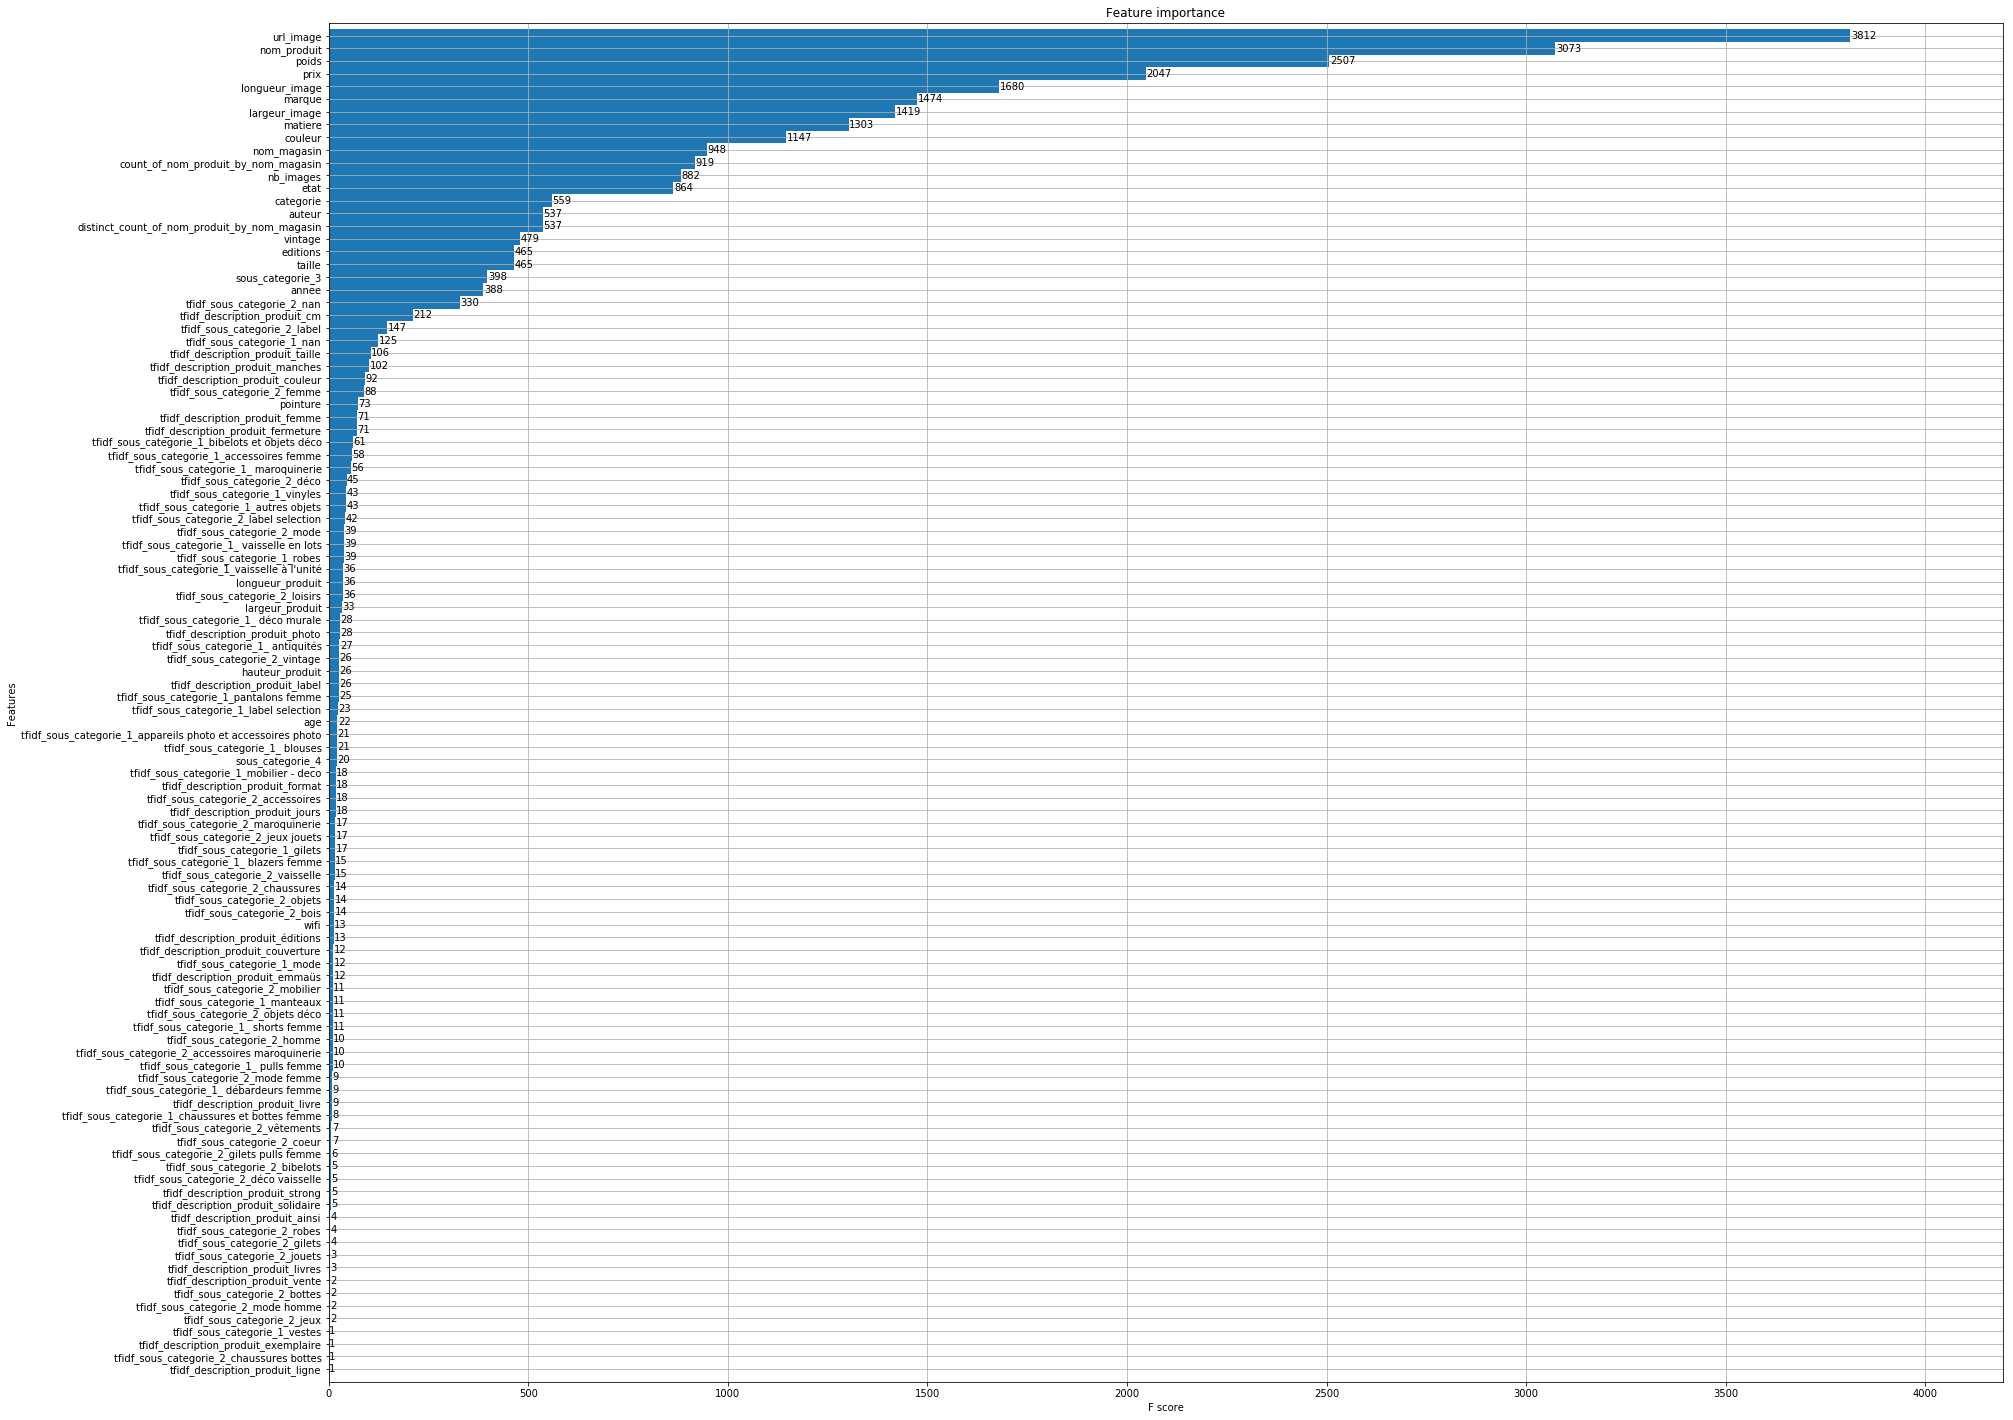

In [8]:
import matplotlib.pyplot as plt

def plot_xgb_importance(number_round, params, train_df, test_df, target_df):
    d_train = xgb.DMatrix(csr_matrix(train_df), label=target_df, feature_names=train_df.columns.values)
    d_test = xgb.DMatrix(csr_matrix(test_df))
    clf = xgb.train(params, d_train, number_round)
    
    fig, ax = plt.subplots(figsize=(30,25))
    xgb.plot_importance(clf, max_num_features=500, height=1, ax=ax)
    plt.show()
    return

plot_xgb_importance(best_round, xgb_params, train, test, target)